In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os
import shutil
# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score,
    recall_score, f1_score,
    classification_report, confusion_matrix
)

# MLflow tracking
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

In [4]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("Customer Churn Prediction")

<Experiment: artifact_location='s3://s3-churn/1', creation_time=1745728957405, experiment_id='1', last_update_time=1745728957405, lifecycle_stage='active', name='Customer Churn Prediction', tags={'mlflow.sharedViewState.f9cbb98e7827c2a2615434cfc5dbc9f9c23b9a6268feed2a3bef82206d68bb20': 'deflate;eJxdUtFOAjEQ/BXTZ2Lw9d4OBCWCMQcSE2KgtAu3Sa8l3S2ChH93D05BHnd2ZrY724Mi0NGUfXQMUWVKtVSIFmJn/wJ7qTVzxGVioHtiHXnOWMGFlJNR2Uo7gpY69Sd1O1P5cCgkhyswe+Pgzz43jNtabzVrAqbfzuyzpapgwU0hEgZ/UTh3VyRPoiFwYBhsN7hUCZLNrp+3GIcUDSyEeI2OalO6RR/P4xdKxkZx7+022luwKjscz8gbel/Xs4bxjNaCv61rd3lkf1CMJ/OH9rx4fx3LqC3C10jvsMLv2qMJSGRDJP51alCk3BiJU5Yu4BTrlSQRPMWQNmCn2iWgge+WkrLszjFJv0QLvWrD+//wutZ05H4+OdeUNzvqxKGAVQQqe14v3dXQtQtL7Ybo4eTaDX6Fa1GpXb5DOv8LYticLuxhXIXApQeS8e3LlT5q8ggkc3OWqOPxB/TD3fI='}>

In [5]:
path = kagglehub.dataset_download('blastchar/telco-customer-churn', force_download=True)
destination_path = '/root/code/customer-churn-mlops/Dataset'
shutil.copytree(path, destination_path, dirs_exist_ok=True)

100%|██████████| 172k/172k [00:00<00:00, 179kB/s]

Extracting model files...


'/root/code/customer-churn-mlops/Dataset'

The data set includes information about:

Customers who left within the last month – the column is called Churn

Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies

Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges

Demographic info about customers – gender, age range, and if they have partners and dependent



Data Preprocessing & Initial Visualization
Loads the dataset, explores basic information, and creates a correlation heatmap to visualize relationships between numeric features.

In [6]:
import boto3

Dataset Shape: (7043, 21)

Columns: Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   I

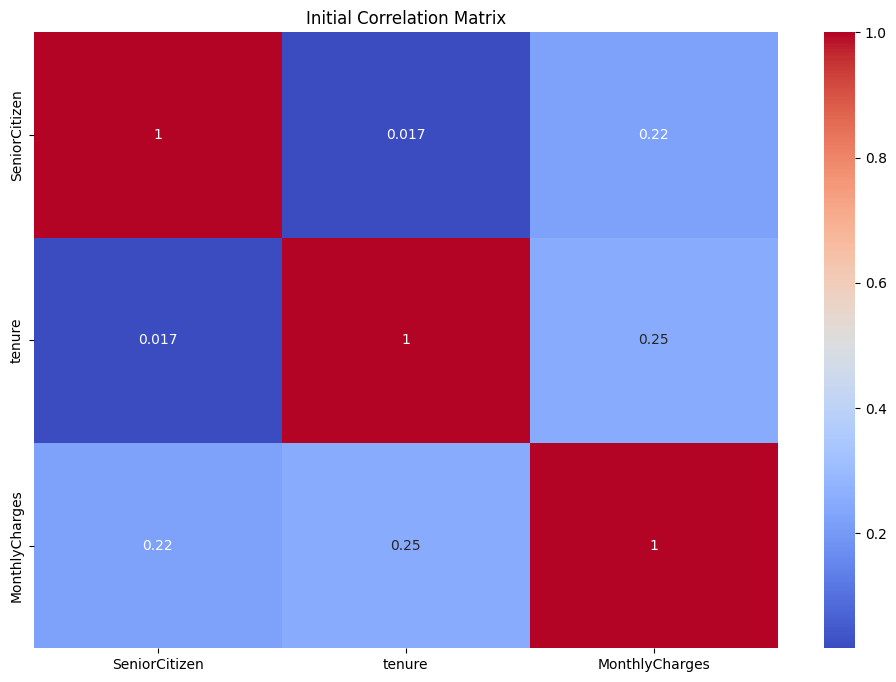

In [7]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
import plotly.express as px
import plotly.graph_objects as go
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Load dataset and check basic information
main_df = pd.read_csv("./Dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df = main_df.copy()

# Show basic dataset information
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns)
df.info()
df.nunique()
df.describe()

# Visualize initial data distribution and correlations
# 1. Correlation Heatmap
plt.figure(figsize=(12, 8))
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Initial Correlation Matrix")
plt.show()

Data Cleaning & Feature Engineering
Cleans the dataset by dropping unnecessary columns, handling missing values, and visualizing relationships between key features.

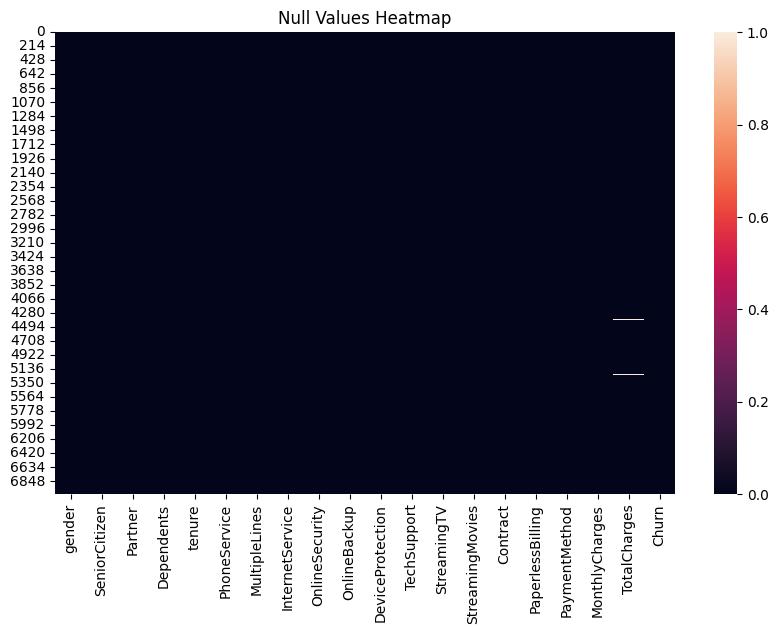

Missing Values Count:
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


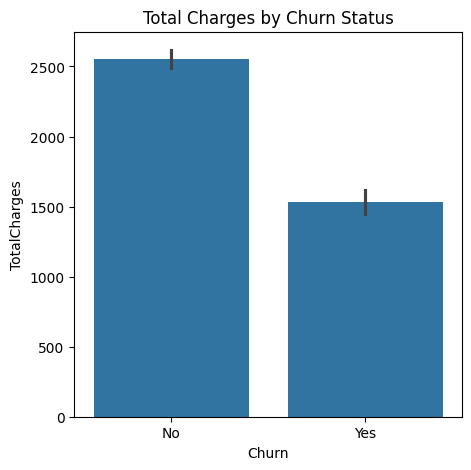

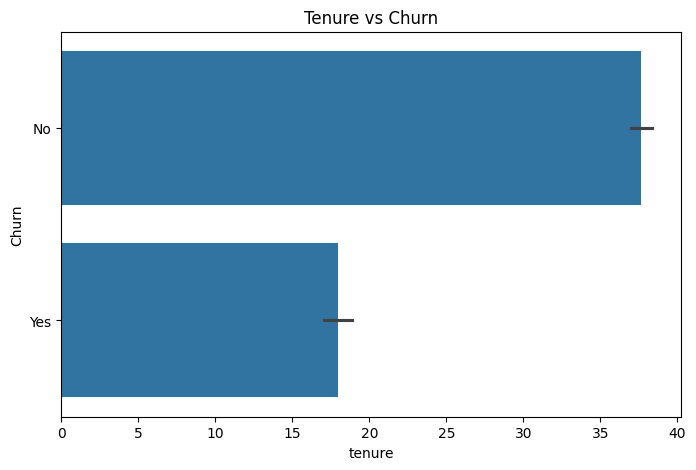

In [8]:
# Drop unnecessary columns and handle missing values
df = df.drop('customerID', axis=1)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors="coerce")

# Check and visualize missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull())
plt.title("Null Values Heatmap")
plt.show()

print("Missing Values Count:")
print(df.isnull().sum())

# Handle missing values
df.drop(df[df['TotalCharges'].isnull()].index, inplace=True)
df.reset_index(drop=True, inplace=True)

# Visualize relationships between key features
# 1. Total Charges by Churn
plt.figure(figsize=(5, 5))
sns.barplot(data=df, y="TotalCharges", x="Churn")
plt.title("Total Charges by Churn Status")
plt.show()

# 2. Tenure vs Churn
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x="tenure", y="Churn")
plt.title("Tenure vs Churn")
plt.show()

# 3. Total Charges vs Tenure
fig = px.scatter(df, y="TotalCharges", x="tenure")
fig.update_layout(title="Total Charges vs Tenure")
fig.show()

Data Preprocessing for Categorical Features


In [9]:
# Replace categorical values
df.replace('No internet service', 'No', inplace=True)
df.replace('No phone service', 'No', inplace=True)

# Display unique values in categorical columns
for i in df.columns:
    if df[i].dtypes=="object":
        print(f'{i} : {df[i].unique()}')
        print("****************************************************")

# Convert gender to numeric
df['gender'].replace({'Female':1,'Male':0}, inplace=True)

gender : ['Female' 'Male']
****************************************************
Partner : ['Yes' 'No']
****************************************************
Dependents : ['No' 'Yes']
****************************************************
PhoneService : ['No' 'Yes']
****************************************************
MultipleLines : ['No' 'Yes']
****************************************************
InternetService : ['DSL' 'Fiber optic' 'No']
****************************************************
OnlineSecurity : ['No' 'Yes']
****************************************************
OnlineBackup : ['Yes' 'No']
****************************************************
DeviceProtection : ['No' 'Yes']
****************************************************
TechSupport : ['No' 'Yes']
****************************************************
StreamingTV : ['No' 'Yes']
****************************************************
StreamingMovies : ['No' 'Yes']
****************************************************
Contract : 

Churn Analysis Visualizations

In [10]:
# Churn distribution by Senior Citizen status
diag = px.histogram(df, x="Churn", color="SeniorCitizen")
diag.update_layout(width=750, height=550, title="Churn Distribution by Senior Citizen Status")
diag.show()

# Total Charges distribution by Churn
diag = px.pie(df, values='TotalCharges', names='Churn', hole=0.5)
diag.update_layout(title="Total Charges Distribution by Churn")
diag.show()

Service and Contract Analysis Visualizations

In [11]:
# 1. Multiple Lines Distribution
labels = df['MultipleLines'].unique()
values = df['MultipleLines'].value_counts()
diag = go.Figure(data=[go.Pie(labels=labels, values=values, pull=[0, 0.1, 0.2])])
diag.update_layout(
    title="Multiple Lines Distribution",
    width=600, height=400
)
diag.show()

# 2. Internet Service Distribution
labels = df['InternetService'].unique()
values = df['InternetService'].value_counts()
diag = go.Figure(data=[go.Pie(labels=labels, values=values, pull=[0, 0.2, 0.3])])
diag.update_layout(
    title="Internet Service Distribution",
    width=600, height=400
)
diag.show()

# 3. Payment Method Distribution
labels = df['PaymentMethod'].unique()
values = df['PaymentMethod'].value_counts()
diag = go.Figure(data=[go.Pie(labels=labels, values=values, pull=[0, 0, 0.2, 0])])
diag.update_layout(
    title="Payment Method Distribution",
    width=600, height=400
)
diag.show()

# 4. Contract Type Distribution
labels = df['Contract'].unique()
values = df['Contract'].value_counts()
diag = go.Figure(data=[go.Pie(labels=labels, values=values, pull=[0, 0.2, 0.3])])
diag.update_layout(
    title="Contract Type Distribution",
    width=600, height=400
)
diag.show()

Feature Engineering
Performs one-hot encoding for multi-category variables and scales numerical features. One-hot encoding is used to convert categorical variables into numerical format, which is necessary for machine learning algorithms.

In [12]:
print(df.columns)


Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


In [13]:
# One-hot encoding for multi-category variables
# Handle variables with more than 2 categories
more_than_2 = ['InternetService' ,'Contract' ,'PaymentMethod']
df = pd.get_dummies(data=df, columns=more_than_2)

# Feature scaling for numerical columns
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Scale continuous variables
large_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
df[large_cols] = scaler.fit_transform(df[large_cols])

# Convert binary categories to numeric
two_cate = ['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
            'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
            'TechSupport', 'StreamingTV', 'StreamingMovies', 
            'PaperlessBilling', 'Churn']
for i in two_cate:
    df[i].replace({"No":0, "Yes":1}, inplace=True)

Final Data Processing and Analysis
Visualizes final correlations after feature engineering and splits the data into features and target.

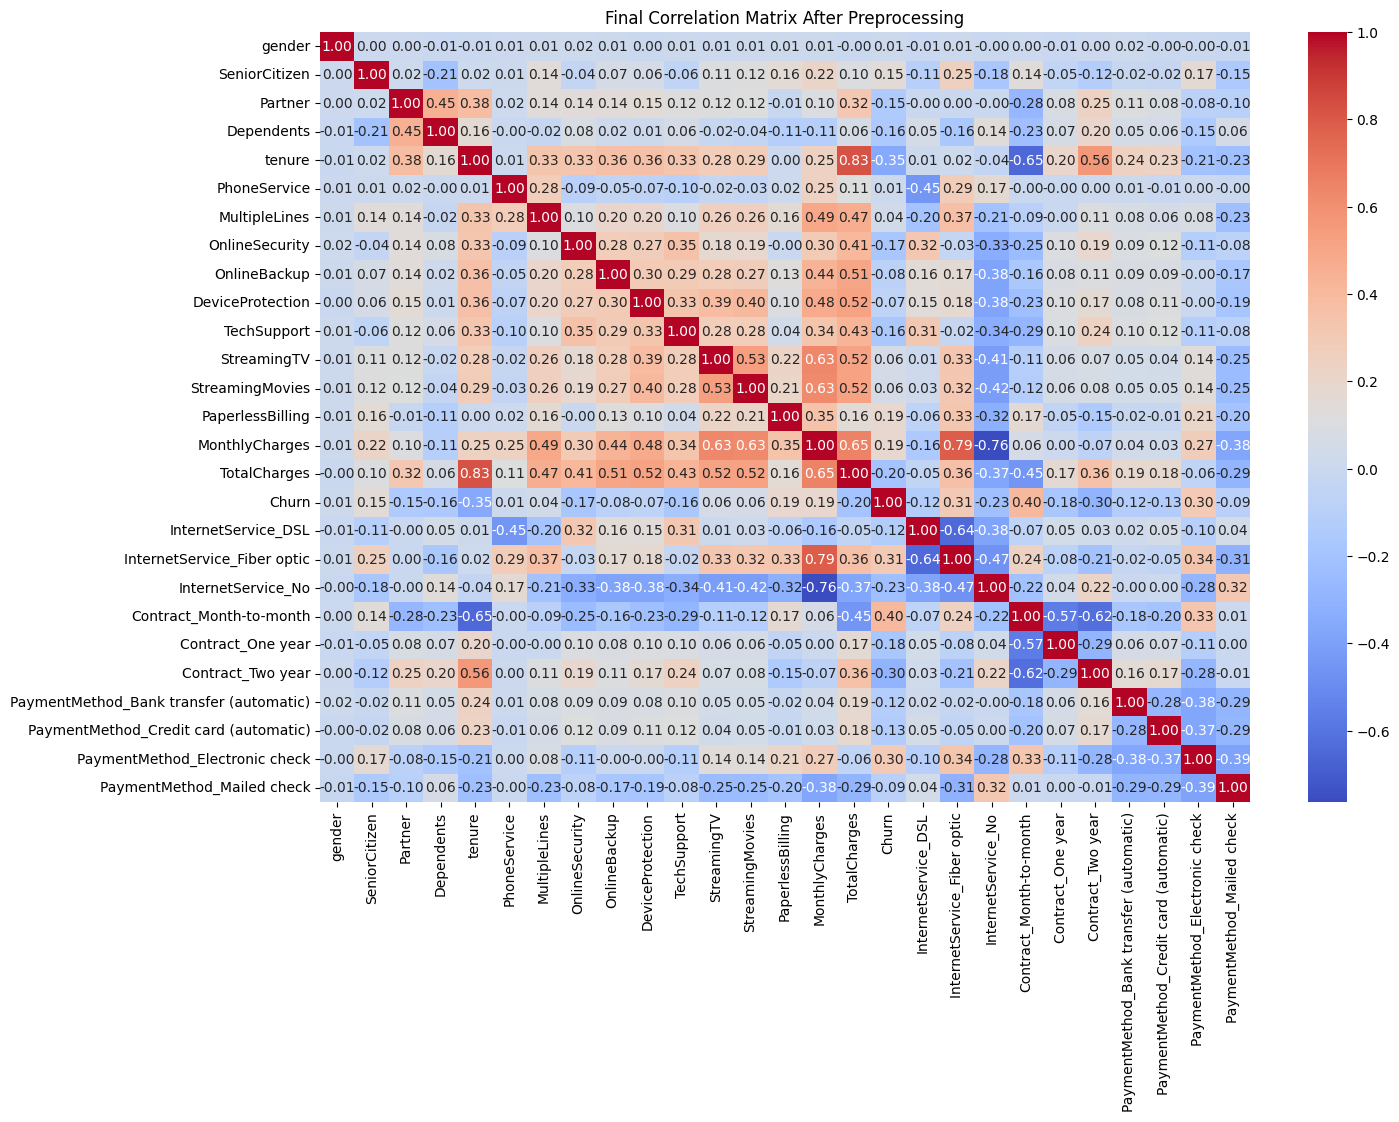

Preparing features and target...

Feature set shape: (7032, 26)
Target shape: (7032,)

Training set shape: (4711, 26)
Testing set shape: (2321, 26)


In [14]:
# Visualize final correlations after feature engineering
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Final Correlation Matrix After Preprocessing")
plt.show()

# Split features and target
print("Preparing features and target...")
X = df.drop('Churn', axis=1)
y = df['Churn']

print("\nFeature set shape:", X.shape)
print("Target shape:", y.shape)

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.33, 
    random_state=42
)

print("\nTraining set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Model Training & MLflow Tracking
For training the Customer Churn Prediction model, we will use 7 different ML models. For each model we will track various parameters, metrics, and artifacts with best practices of MLOps.

Logistic Regression
Implements logistic regression for binary classification. Tracks parameters, metrics, and artifacts using MLflow.

MLflow Tracking:

Parameters: max_iter, random_state, n_jobs

Metrics: Accuracy, Precision, Recall, F1 Score
Artifacts: Confusion Matrix, Classification Report, Trained Model


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import mlflow
from mlflow.models import infer_signature

with mlflow.start_run(run_name="logistic_regression"):
    # Create and train model
    model_lg = LogisticRegression(max_iter=120, random_state=0, n_jobs=20)
    
    # Log parameters
    mlflow.log_params({
        "max_iter": 120,
        "random_state": 0,
        "n_jobs": 20
    })
    
    # Train model
    model_lg.fit(X_train, y_train)
    
    # Make predictions
    pred_lg = model_lg.predict(X_test)
    
    # Calculate and log accuracy
    lg = round(accuracy_score(y_test, pred_lg) * 100, 2)
    mlflow.log_metric("accuracy", lg)
    
    # Log classification report
    clf_report = classification_report(y_test, pred_lg)
    with open("lg_classification_report.txt", "w") as f:
        f.write(clf_report)
    mlflow.log_artifact("lg_classification_report.txt")
    
    # Create and log confusion matrix
    plt.figure(figsize=(8, 6))
    cm1 = confusion_matrix(y_test, pred_lg)
    sns.heatmap(cm1 / np.sum(cm1), annot=True, fmt='.2%', cmap="Reds")
    plt.title("Logistic Regression Confusion Matrix")
    plt.savefig("lg_confusion_matrix.png")
    plt.close()
    mlflow.log_artifact("lg_confusion_matrix.png")
    
    # Calculate and log additional metrics
    precision = precision_score(y_test, pred_lg)
    recall = recall_score(y_test, pred_lg)
    f1 = f1_score(y_test, pred_lg)
    mlflow.log_metrics({
        "precision": precision,
        "recall": recall,
        "f1": f1
    })
    
    # Log the model
    signature = infer_signature(X_train, pred_lg)
    mlflow.sklearn.log_model(model_lg, "logistic_regression_model", signature=signature)

print(f"Logistic Regression Accuracy: {lg}%")
print("\nClassification Report:")
print(clf_report)

2025/04/27 05:22:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run logistic_regression at: http://localhost:5000/#/experiments/1/runs/cfc36254ccbd44beb7ac49093298e984.
2025/04/27 05:22:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.


Logistic Regression Accuracy: 80.01%

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1711
           1       0.64      0.54      0.58       610

    accuracy                           0.80      2321
   macro avg       0.74      0.72      0.73      2321
weighted avg       0.79      0.80      0.79      2321



Decision Tree
Trains a decision tree classifier for binary classification. Tracks parameters, metrics, and artifacts using MLflow.

MLflow Tracking:

Parameters: max_depth, random_state

Metrics: Accuracy, Precision, Recall, F1 Score

Artifacts: Confusion Matrix, Classification Report, Trained Model

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import mlflow
from mlflow.models import infer_signature

with mlflow.start_run(run_name="decision_tree"):
    # Create and train model
    model_dt = DecisionTreeClassifier(max_depth=4, random_state=42)
    
    # Log parameters
    mlflow.log_params({
        "max_depth": 4,
        "random_state": 42
    })
    
    # Train model
    model_dt.fit(X_train, y_train)
    
    # Make predictions
    pred_dt = model_dt.predict(X_test)
    
    # Calculate and log accuracy
    dt = round(accuracy_score(y_test, pred_dt) * 100, 2)
    mlflow.log_metric("accuracy", dt)
    
    # Log classification report
    clf_report = classification_report(y_test, pred_dt)
    with open("dt_classification_report.txt", "w") as f:
        f.write(clf_report)
    mlflow.log_artifact("dt_classification_report.txt")
    
    # Create and log confusion matrix
    plt.figure(figsize=(8, 6))
    cm2 = confusion_matrix(y_test, pred_dt)
    sns.heatmap(cm2 / np.sum(cm2), annot=True, fmt='.2%', cmap="Reds")
    plt.title("Decision Tree Classifier Confusion Matrix")
    plt.savefig("dt_confusion_matrix.png")
    plt.close()
    mlflow.log_artifact("dt_confusion_matrix.png")
    
    # Calculate and log additional metrics
    precision = precision_score(y_test, pred_dt, average="weighted")
    recall = recall_score(y_test, pred_dt, average="weighted")
    f1 = f1_score(y_test, pred_dt, average="weighted")
    mlflow.log_metrics({
        "precision": precision,
        "recall": recall,
        "f1": f1
    })
    
    # Log the model
    signature = infer_signature(X_train, pred_dt)
    mlflow.sklearn.log_model(model_dt, "decision_tree_model", signature=signature)

print(f"Decision Tree Accuracy: {dt}%")
print("\nClassification Report:")
print(clf_report)

2025/04/27 05:22:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run decision_tree at: http://localhost:5000/#/experiments/1/runs/d625c7aa7bfd473f8bc2c85c72664565.
2025/04/27 05:22:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.


Decision Tree Accuracy: 78.89%

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1711
           1       0.63      0.48      0.54       610

    accuracy                           0.79      2321
   macro avg       0.73      0.69      0.70      2321
weighted avg       0.78      0.79      0.78      2321



Random Forest
Trains a random forest classifier for binary classification. Tracks parameters, metrics, and artifacts using MLflow.

MLflow Tracking:

Parameters: n_estimators, min_samples_leaf, random_state

Metrics: Accuracy, Precision, Recall, F1 Score

Artifacts: Confusion Matrix, Classification Report, Feature Importance, Trained Model

In [17]:
from sklearn.ensemble import RandomForestClassifier

with mlflow.start_run(run_name="random_forest"):
    # Create and train model
    model_rf = RandomForestClassifier(n_estimators=300, min_samples_leaf=0.16, random_state=42)
    
    # Log parameters
    mlflow.log_params({
        "n_estimators": 300,
        "min_samples_leaf": 0.16,
        "random_state": 42
    })
    
    # Train model
    model_rf.fit(X_train, y_train)
    
    # Make predictions
    pred_rf = model_rf.predict(X_test)
    
    # Calculate and log accuracy
    rf = round(accuracy_score(y_test, pred_rf) * 100, 2)
    mlflow.log_metric("accuracy", rf)
    
    # Log classification report
    clf_report = classification_report(y_test, pred_rf)
    with open("rf_classification_report.txt", "w") as f:
        f.write(clf_report)
    mlflow.log_artifact("rf_classification_report.txt")
    
    # Create and log confusion matrix
    plt.figure(figsize=(8, 6))
    cm3 = confusion_matrix(y_test, pred_rf)
    sns.heatmap(cm3 / np.sum(cm3), annot=True, fmt='.2%', cmap="Reds")
    plt.title("Random Forest Confusion Matrix")
    plt.savefig("rf_confusion_matrix.png")
    plt.close()
    mlflow.log_artifact("rf_confusion_matrix.png")
    
    # Calculate and log additional metrics
    precision = precision_score(y_test, pred_rf, average="weighted")
    recall = recall_score(y_test, pred_rf, average="weighted")
    f1 = f1_score(y_test, pred_rf, average="weighted")
    mlflow.log_metrics({
        "precision": precision,
        "recall": recall,
        "f1": f1
    })
    
    # Log feature importance
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': model_rf.feature_importances_
    }).sort_values('importance', ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
    plt.title("Top 10 Feature Importance - Random Forest")
    plt.savefig("rf_feature_importance.png")
    plt.close()
    mlflow.log_artifact("rf_feature_importance.png")
    
    # Log the model
    signature = infer_signature(X_train, pred_rf)
    mlflow.sklearn.log_model(model_rf, "random_forest_model", signature=signature)

print(f"Random Forest Metrics: Accuracy={rf}%, Precision={precision}, Recall={recall}, F1={f1}")


2025/04/27 05:22:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run random_forest at: http://localhost:5000/#/experiments/1/runs/25082c4e084d42009fb371d275e2d717.
2025/04/27 05:22:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.


Random Forest Metrics: Accuracy=73.72%, Precision=0.5434376682857992, Recall=0.7371822490305903, F1=0.6256541806008632


XGBoost
Trains an XGBoost classifier for binary classification. Tracks parameters, metrics, and artifacts using MLflow.

MLflow Tracking:

Parameters: max_depth, n_estimators, learning_rate, random_state, n_jobs

Metrics: Accuracy, Precision, Recall, F1 Score

Artifacts: Confusion Matrix, Classification Report, Trained Model

In [18]:
from xgboost import XGBClassifier

with mlflow.start_run(run_name="xgboost"):
    # Create and train model
    model_xgb = XGBClassifier(max_depth=8, n_estimators=125, random_state=0, 
                              learning_rate=0.03, n_jobs=5)
    
    # Log parameters
    mlflow.log_params({
        "max_depth": 8,
        "n_estimators": 125,
        "learning_rate": 0.03,
        "random_state": 0,
        "n_jobs": 5
    })
    
    # Train model
    model_xgb.fit(X_train, y_train)
    
    # Make predictions
    pred_xgb = model_xgb.predict(X_test)
    
    # Calculate and log accuracy
    xgb = round(accuracy_score(y_test, pred_xgb) * 100, 2)
    mlflow.log_metric("accuracy", xgb)
    
    # Log classification report
    clf_report = classification_report(y_test, pred_xgb)
    with open("xgb_classification_report.txt", "w") as f:
        f.write(clf_report)
    mlflow.log_artifact("xgb_classification_report.txt")
    
    # Log confusion matrix
    plt.figure(figsize=(8, 6))
    cm4 = confusion_matrix(y_test, pred_xgb)
    sns.heatmap(cm4 / np.sum(cm4), annot=True, fmt='.2%', cmap="Reds")
    plt.title("XGBoost Confusion Matrix")
    plt.savefig("xgb_confusion_matrix.png")
    plt.close()
    mlflow.log_artifact("xgb_confusion_matrix.png")
    
    # Log model
    signature = infer_signature(X_train, pred_xgb)
    mlflow.sklearn.log_model(model_xgb, "xgboost_model", signature=signature)

print(f"XGBoost Metrics: Accuracy={xgb}%, Precision={precision}, Recall={recall}, F1={f1}")

2025/04/27 05:22:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run xgboost at: http://localhost:5000/#/experiments/1/runs/8ae1d89ea89a4a3b8d2eecad5e81311f.
2025/04/27 05:22:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.


XGBoost Metrics: Accuracy=79.06%, Precision=0.5434376682857992, Recall=0.7371822490305903, F1=0.6256541806008632


KNeighborsClassifier
Trains a KNeighbors classifier for binary classification. Tracks parameters, metrics, and artifacts using MLflow.

MLflow Tracking:

Parameters: n_neighbors, leaf_size

Metrics: Accuracy, Precision, Recall, F1 Score

Artifacts: Confusion Matrix, Classification Report, Trained Mode

In [19]:
from sklearn.neighbors import KNeighborsClassifier

with mlflow.start_run(run_name="kneighbors"):
    # Create model
    model_kn = KNeighborsClassifier(n_neighbors=9, leaf_size=20)
    
    # Log parameters
    mlflow.log_params({
        "n_neighbors": 9,
        "leaf_size": 20
    })
    
    # Train model
    model_kn.fit(X_train, y_train)
    
    # Make predictions
    pred_kn = model_kn.predict(X_test)
    
    # Calculate and log accuracy
    kn = round(accuracy_score(y_test, pred_kn) * 100, 2)
    mlflow.log_metric("accuracy", kn)
    
    # Log classification report
    clf_report = classification_report(y_test, pred_kn)
    with open("kn_classification_report.txt", "w") as f:
        f.write(clf_report)
    mlflow.log_artifact("kn_classification_report.txt")
    
    # Log confusion matrix
    plt.figure(figsize=(8, 6))
    cm5 = confusion_matrix(y_test, pred_kn)
    sns.heatmap(cm5 / np.sum(cm5), annot=True, fmt='.2%', cmap="Reds")
    plt.title("KNeighbors Confusion Matrix")
    plt.savefig("kn_confusion_matrix.png")
    plt.close()
    mlflow.log_artifact("kn_confusion_matrix.png")
    
    # Log model
    signature = infer_signature(X_train, pred_kn)
    mlflow.sklearn.log_model(model_kn, "kneighbors_model", signature=signature)

print(f"KNeighbors Metrics: Accuracy={kn}%, Precision={precision}, Recall={recall}, F1={f1}")



2025/04/27 05:22:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run kneighbors at: http://localhost:5000/#/experiments/1/runs/c4599c9104ae4893a52d3353527fad58.
2025/04/27 05:22:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.


KNeighbors Metrics: Accuracy=76.99%, Precision=0.5434376682857992, Recall=0.7371822490305903, F1=0.6256541806008632


from sklearn.neighbors import KNeighborsClassifier


SVM
Trains a Support Vector Machine (SVM) classifier using the RBF kernel for binary classification. Tracks parameters, metrics, and artifacts with MLflow.

MLflow Tracking:

Parameters: kernel, random_state

Metrics: Accuracy, Precision, Recall, F1 Score

Artifacts: Confusion Matrix, Classification Report, Trained Model

In [20]:
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import mlflow
from mlflow.models import infer_signature

with mlflow.start_run(run_name="svm_classifier"):
    # Create and train model
    model_svm = SVC(kernel='rbf', random_state=42)
    
    # Log parameters
    mlflow.log_params({
        "kernel": "rbf",
        "random_state": 42
    })
    
    # Train model
    model_svm.fit(X_train, y_train)
    
    # Make predictions
    pred_svm = model_svm.predict(X_test)
    
    # Calculate and log accuracy
    sv = round(accuracy_score(y_test, pred_svm)*100, 2)
    mlflow.log_metric("accuracy", sv)
    
    # Log classification report
    clf_report = classification_report(y_test, pred_svm)
    with open("svm_classification_report.txt", "w") as f:
        f.write(clf_report)
    mlflow.log_artifact("svm_classification_report.txt")
    
    # Create and log confusion matrix
    plt.figure(figsize=(8, 6))
    cm6 = confusion_matrix(y_test, pred_svm)
    sns.heatmap(cm6/np.sum(cm6), annot=True, fmt='0.2%', cmap="Reds")
    plt.title("SVM Classifier Confusion Matrix")
    plt.savefig("svm_confusion_matrix.png")
    plt.close()
    mlflow.log_artifact("svm_confusion_matrix.png")
    
    # Log additional metrics
    mlflow.log_metrics({
        "precision": precision_score(y_test, pred_svm),
        "recall": recall_score(y_test, pred_svm),
        "f1": f1_score(y_test, pred_svm)
    })
    
    # Log the model
    signature = infer_signature(X_train, pred_svm)
    mlflow.sklearn.log_model(model_svm, "svm_model", signature=signature)

print(f"SVM Classifier Accuracy: {sv}%")
print("\nClassification Report:")
print(classification_report(y_test, pred_svm))

2025/04/27 05:22:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run svm_classifier at: http://localhost:5000/#/experiments/1/runs/976e63a7c56546128e913d892f5c5b62.
2025/04/27 05:22:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.


SVM Classifier Accuracy: 79.84%

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1711
           1       0.65      0.50      0.57       610

    accuracy                           0.80      2321
   macro avg       0.74      0.70      0.72      2321
weighted avg       0.79      0.80      0.79      2321



AdaBoost Classifier
Trains an AdaBoost classifier for binary classification. Tracks parameters, metrics, and artifacts with MLflow.

MLflow Tracking:

Parameters: learning_rate, n_estimators, random_state

Metrics: Accuracy, Precision, Recall, F1 Score

Artifacts: Confusion Matrix, Classification Report, Feature Importance, Trained Model

AdaBoost Classifier
Trains an AdaBoost classifier for binary classification. Tracks parameters, metrics, and artifacts with MLflow.

MLflow Tracking:

Parameters: learning_rate, n_estimators, random_state

Metrics: Accuracy, Precision, Recall, F1 Score

Artifacts: Confusion Matrix, Classification Report, Feature Importance, Trained Model

In [21]:
from sklearn.ensemble import AdaBoostClassifier

with mlflow.start_run(run_name="adaboost"):
    # Create model
    model_ada = AdaBoostClassifier(
        learning_rate=0.002,
        n_estimators=205,
        random_state=42
    )
    
    # Log parameters
    mlflow.log_params({
        "learning_rate": 0.002,
        "n_estimators": 205,
        "random_state": 42
    })
    
    # Train model
    model_ada.fit(X_train, y_train)
    
    # Make predictions
    pred_ada = model_ada.predict(X_test)
    
    # Calculate and log accuracy
    ada = round(accuracy_score(y_test, pred_ada) * 100, 2)
    mlflow.log_metric("accuracy", ada)
    
    # Log classification report
    clf_report = classification_report(y_test, pred_ada)
    with open("ada_classification_report.txt", "w") as f:
        f.write(clf_report)
    mlflow.log_artifact("ada_classification_report.txt")
    
    # Log confusion matrix
    plt.figure(figsize=(8, 6))
    cm7 = confusion_matrix(y_test, pred_ada)
    sns.heatmap(cm7 / np.sum(cm7), annot=True, fmt='.2%', cmap="Reds")
    plt.title("AdaBoost Confusion Matrix")
    plt.savefig("ada_confusion_matrix.png")
    plt.close()
    mlflow.log_artifact("ada_confusion_matrix.png")
    
    # Log feature importance
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': model_ada.feature_importances_
    }).sort_values('importance', ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
    plt.title("Top 10 Feature Importance - AdaBoost")
    plt.savefig("ada_feature_importance.png")
    plt.close()
    mlflow.log_artifact("ada_feature_importance.png")
    
    # Log model
    signature = infer_signature(X_train, pred_ada)
    mlflow.sklearn.log_model(model_ada, "adaboost_model", signature=signature)

print(f"AdaBoost Metrics: Accuracy={ada}%, Precision={precision}, Recall={recall}, F1={f1}")

2025/04/27 05:22:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run adaboost at: http://localhost:5000/#/experiments/1/runs/2c8b772ffa76449c9065f84c4e0e2fa0.
2025/04/27 05:22:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.


AdaBoost Metrics: Accuracy=73.72%, Precision=0.5434376682857992, Recall=0.7371822490305903, F1=0.6256541806008632


Model Comparison
To compare the performance of different models, we will create a bar plot visualization and CSV files with accuracy metrics. For this we will use the accuracy scores of each model.

In [22]:
# Create and log model comparison visualization in MLflow
with mlflow.start_run(run_name="model_comparison"):
    # Create DataFrame with model performances
    models = pd.DataFrame({
        'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 
                'XGBoost', 'KNN', 'SVM', 'AdaBoost'],
        'Accuracy': [lg, dt, rf, xgb, kn, sv, ada]
    })
    
    # Create comparison plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Accuracy', y='Model', data=models)
    plt.title('Model Performance Comparison')
    plt.xlabel('Accuracy Score (%)')
    plt.ylabel('Models')
    
    # Save plot
    plt.savefig("model_comparison.png")
    plt.close()
    
    # Log the comparison plot
    mlflow.log_artifact("model_comparison.png")
    
    # Log individual model accuracies
    for model, accuracy in zip(models['Model'], models['Accuracy']):
        mlflow.log_metric(f"{model.lower().replace(' ', '_')}_accuracy", accuracy)
    
    # Log the comparison table as CSV
    models.to_csv("model_comparison.csv", index=False)
    mlflow.log_artifact("model_comparison.csv")
    
    # Create and log sorted accuracies table
    sorted_models = models.sort_values(by='Accuracy', ascending=False)
    print("\nModel Accuracies Ranked:")
    print(sorted_models)
    
    # Save sorted results
    sorted_models.to_csv("sorted_model_comparison.csv", index=False)
    mlflow.log_artifact("sorted_model_comparison.csv")

2025/04/27 05:22:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run model_comparison at: http://localhost:5000/#/experiments/1/runs/8fd036f29c7a4faf85133b7b0efb48f6.
2025/04/27 05:22:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



Model Accuracies Ranked:
                 Model  Accuracy
0  Logistic Regression     80.01
5                  SVM     79.84
3              XGBoost     79.06
1        Decision Tree     78.89
4                  KNN     76.99
2        Random Forest     73.72
6             AdaBoost     73.72


Register Best Model
To register the best model, we will use the MlflowClient to search for the best run based on accuracy and then register the model from the best run to the model registry and transition it to the 'Production' stage.

In [23]:
from mlflow.tracking import MlflowClient

def register_best_model(experiment_name="Customer Churn Prediction"):
    """
    Registers the best-performing model from the MLflow experiment
    to the model registry and transitions it to the 'Production' stage.
    """
    client = MlflowClient()
    
    # Retrieve experiment details
    experiment = client.get_experiment_by_name(experiment_name)
    if not experiment:
        raise ValueError(f"Experiment '{experiment_name}' not found.")
    
    # Identify the best run based on a key metric (e.g., accuracy)
    best_run = client.search_runs(
        experiment_ids=[experiment.experiment_id],
        order_by=["metrics.accuracy DESC"]
    )[0]
    
    # Register the model from the best run
    model_uri = f"runs:/{best_run.info.run_id}/model"
    model_name = "customer_churn_prediction_model"
    model_version = mlflow.register_model(model_uri, model_name)
    
    # Transition the model to the 'Production' stage
    client.transition_model_version_stage(
        name=model_name,
        version=model_version.version,
        stage="Production"
    )
    
    print(f"Model {model_name} version {model_version.version} is now in 'Production' stage.")
    return model_version

# Call the function after model training and comparison
best_model_version = register_best_model()
print(f"Registered model version: {best_model_version.version}")

Registered model 'customer_churn_prediction_model' already exists. Creating a new version of this model...
2025/04/27 05:22:49 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: customer_churn_prediction_model, version 2


Model customer_churn_prediction_model version 2 is now in 'Production' stage.
Registered model version: 2


Created version '2' of model 'customer_churn_prediction_model'.


Verification
Model Tracking Verification in MLflow
Navigate to the MLflow UI with url provided by the Poridhi's Loadbalancer.

Navigate to "Experiments" tab and select "Customer Churn Prediction-lab-01"

For each model run, verify the parameters, metrics, and artifacts.For example we can see the overview, metrics & artifacts for SVM: Overview of SVM:

Model Metrics:

Artifacts:

By following the above steps, you can verify the parameters, metrics, and artifacts for other models as well.

Model Comparison Verification
In the MLflow UI, navigate to "Model Comparison" experiment and verify the comparison plot and CSV files with accuracy metrics.

Register Best Model Verification
In the MLflow UI, navigate to "Model Registry" and verify the registered model and its version in the "Production" stage.

S3 Artifact Verification
Go to AWS Console and navigate to S3 bucket <your-bucket-name> to verify the artifacts.

For each model run, you should see the artifacts in the S3 bucket.

PostgreSQL Verification
Connect to the PostgreSQL container: docker exec -it <postgres-container-id> /bin/sh

Connect to PostgreSQL: psql -h localhost -U mlflow -d mlflow  -- View experiments SELECT * FROM experiments;

View runs and metrics: SELECT      r.run_uuid,     r.experiment_id,     m.key as metric_name,     m.value as metric_value FROM runs r JOIN metrics m ON r.run_uuid = m.run_uuid WHERE r.experiment_id = '1' ORDER BY r.start_time DESC;

Conclusion
In this lab, we implemented a complete MLOps pipeline for a customer churn prediction problem. We used MLflow for model tracking, S3 for artifact storage, and PostgreSQL for metadata storage for each model run. The visualization analysis revealed important insights about customer churn patterns, particularly its relationship with service usage, payment methods, and contract types.